# Improving the dollar-cost averaging strategy with price volatility analysis

## 1. Introduction

*What is Dollar-Cost Averaging (DCA)?*

SOME TEXT

In [1]:
import cpi
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.neighbors import KernelDensity
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

%matplotlib inline

Let's set up the simulation. The simulated investors will make purchases for 2 years and consider the previous 2 years of weekly stock prices fluctuations to be relevant.

In [2]:
# Import the equities_toolkit.py
import equities_toolkit as etk

In [3]:
tickers = ['MSFT', 'ABBV', 'XOM', 'T', 'MMM']
colors = ['C2', 'C1', 'C0', 'C3', 'C4']

In [4]:
help(etk.Stocks_Composite)

Help on class Stocks_Composite in module equities_toolkit:

class Stocks_Composite(builtins.object)
 |  Stocks_Composite(tickers: list, **kwargs)
 |  
 |  Collection of stocks for analysis. The stock price history are downloaded
 |  a composite index created.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, tickers: list, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_price_histroy_index(self, date: datetime.datetime) -> int
 |  
 |  get_prices(self, date: datetime.datetime) -> dict
 |  
 |  get_weights(self) -> dict
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [5]:
end = datetime.today().date()
start = end + relativedelta(weeks=-208)

In [6]:
sc = etk.Stocks_Composite(tickers, start=start, end=end, interval='1wk')

<Axes: xlabel='Date', ylabel='Close'>

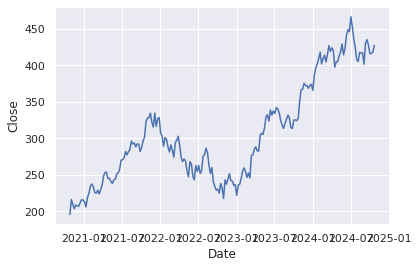

In [7]:
sns.lineplot(x=sc.stocks['MSFT'].price_history.Date, y=sc.stocks['MSFT'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

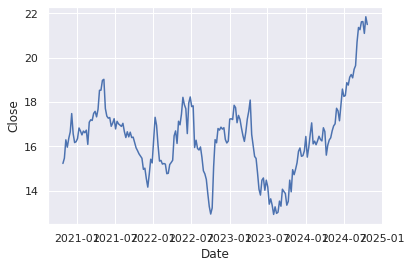

In [8]:
sns.lineplot(x=sc.stocks['T'].price_history.Date, y=sc.stocks['T'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

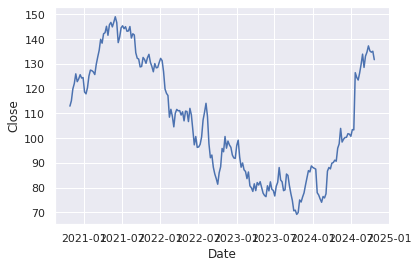

In [9]:
sns.lineplot(x=sc.stocks['MMM'].price_history.Date, y=sc.stocks['MMM'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

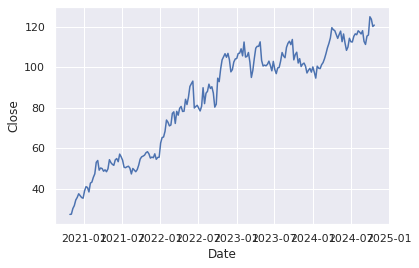

In [10]:
sns.lineplot(x=sc.stocks['XOM'].price_history.Date, y=sc.stocks['XOM'].price_history.Close)

<Axes: xlabel='Date', ylabel='Close'>

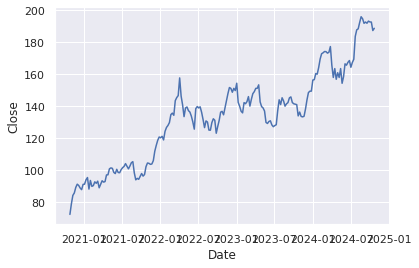

In [11]:
sns.lineplot(x=sc.stocks['ABBV'].price_history.Date, y=sc.stocks['ABBV'].price_history.Close)

In [62]:
dca_xom = sc.stocks['XOM'].price_history.iloc[:len(sc.stocks['XOM'].price_history):2].copy()

In [63]:
dca_xom.drop(columns=['Volume', 'Dividends'], inplace=True)
dca_xom['Cost'] = 500.0  # Amount to invest every 2 weeks

In [64]:
dca_xom['Cum_Cost'] = dca_xom.Cost.cumsum()  

In [65]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost
0,2022-10-17,99.004791,104.748499,500.0,500.0
2,2022-10-31,105.037109,111.130779,500.0,1000.0
4,2022-11-14,104.822006,111.015325,500.0,1500.0
6,2022-11-28,103.572899,109.692415,500.0,2000.0
8,2022-12-12,98.708191,104.862217,500.0,2500.0


In [67]:
dca_xom['Shares'] = dca_xom.Cost / dca_xom.Close
dca_xom['Cum_Shares'] = dca_xom.Shares.cumsum()

In [68]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares
0,2022-10-17,99.004791,104.748499,500.0,500.0,5.050261,5.050261
2,2022-10-31,105.037109,111.130779,500.0,1000.0,4.760222,9.810483
4,2022-11-14,104.822006,111.015325,500.0,1500.0,4.769991,14.580474
6,2022-11-28,103.572899,109.692415,500.0,2000.0,4.827518,19.407991
8,2022-12-12,98.708191,104.862217,500.0,2500.0,5.065436,24.473427


In [72]:
dca_xom['value']= dca_xom.apply(lambda x: x.Close * x.Cum_Shares, axis=1)

In [139]:
total_shares = dca_xom.Cum_Shares.max()

In [336]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [337]:
avg_pps, std_pps = weighted_avg_and_std(dca_xom.Close, dca_xom.Shares)
print(avg_pps, std_pps)

106.77359806165711 6.963200361547471


In [143]:
dca_xom.head()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares,value,mrkr_size
0,2022-10-17,99.004791,104.748499,500.0,500.0,5.050261,5.050261,500.000000,10
2,2022-10-31,105.037109,111.130779,500.0,1000.0,4.760222,9.810483,1030.464779,10
4,2022-11-14,104.822006,111.015325,500.0,1500.0,4.769991,14.580474,1528.354513,10
6,2022-11-28,103.572899,109.692415,500.0,2000.0,4.827518,19.407991,2010.141936,10
8,2022-12-12,98.708191,104.862217,500.0,2500.0,5.065436,24.473427,2415.727726,10


In [144]:
dca_xom.Close.describe()

count     53.000000
mean     107.227701
std        7.136758
min       96.727768
25%      101.346634
50%      105.215408
75%      112.365364
max      124.830002
Name: Close, dtype: float64

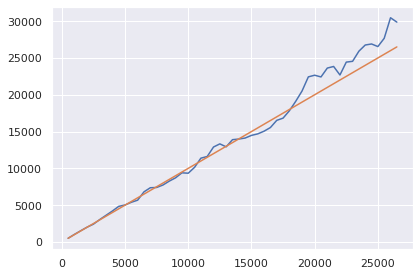

In [98]:
plt.plot(dca_xom.Cum_Cost, dca_xom.value)
plt.plot(dca_xom.Cum_Cost, dca_xom.Cum_Cost)
plt.tight_layout()
plt.show()

In [82]:
dca_gain = ((dca_xom.value.iloc[-1] / dca_xom.Cum_Cost.iloc[-1]) -1)

In [83]:
dca_gain

0.12715128701220846

In [340]:
dca_xom.tail()

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares,value,mrkr_size
96,2024-08-19,116.320000,116.506602,500.0,24500.0,4.298487,231.252136,26899.248394,10
98,2024-09-02,112.639999,112.639999,500.0,25000.0,4.438920,235.691057,26548.240463,10
100,2024-09-16,115.269997,115.269997,500.0,25500.0,4.337642,240.028699,27668.107294,10
102,2024-09-30,124.830002,124.830002,500.0,26000.0,4.005447,244.034146,30462.782899,10
104,2024-10-14,120.349998,120.349998,500.0,26500.0,4.154549,248.188695,29869.509106,10


In [94]:
sc.stocks['XOM'].price_history.drop(columns=['Volume', 'Dividends'], inplace=True)

In [99]:
xom = sc.stocks['XOM'].price_history

In [96]:
# Save the data for tableau
xom.to_csv('xom_20221017-20241014.txt',index_label='week', sep=' ')
dca_xom.to_csv('dca_xom_20221017-20241014.txt', index_label='week', sep=' ')

In [130]:
dca_xom.Close.pct_change().sort_values().head()

86   -0.069504
50   -0.067601
18   -0.063504
28   -0.063184
38   -0.058835
Name: Close, dtype: float64

In [145]:
eg_purchase = dca_xom.loc[[48,50]]
eg_purchase

,Date,Close,Inflation_Adj,Cost,Cum_Cost,Shares,Cum_Shares,value,mrkr_size
48,2023-09-18,111.046440,113.756676,500.0,12500.0,4.502621,119.998331,13325.387496,50
50,2023-10-02,103.539635,106.107337,500.0,13000.0,4.829069,124.827400,12924.583373,50


In [119]:
dca_xom['mrkr_size'] = 10

In [126]:
dca_xom.loc[[48,50], 'mrkr_size'] = 50

In [159]:
annotation_txt = [' 4.5 Shares', ' 4.8 Shares']

In [339]:
eg_purchase.to_csv('eg_purchase_dca_xom.txt', index_label='week', sep=' ')

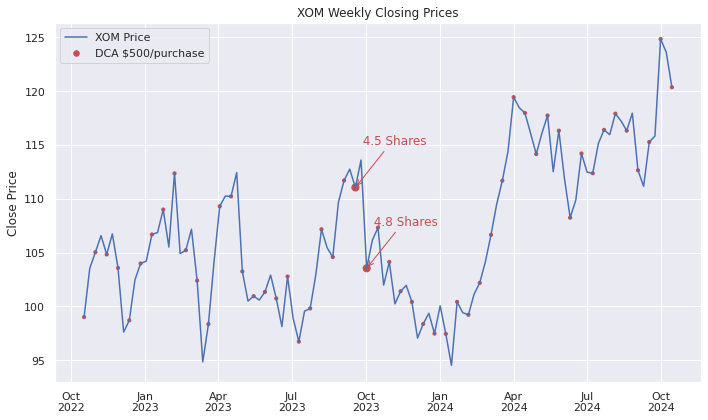

In [195]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(xom['Date'], xom['Close'], label='XOM Price', color='C0')
ax.scatter(dca_xom['Date'], dca_xom['Close'], dca_xom['mrkr_size'], label='DCA $500/purchase', color='C3', marker='o')

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add annotation
arrows = {'arrowstyle':'->', 'color': 'C3'}

for i in range(len(annotation_txt)):
    x = eg_purchase.Date.iloc[i]
    y = eg_purchase.Close.iloc[i]
    ax.annotate(annotation_txt[i], (x, y), xytext=(mdates.date2num(x)+4, y+4), arrowprops=arrows, color='C3')

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Close Price')
ax.set_title('XOM Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## 2. Five Blue-Chip Stock Index Fund

DCA is commonly applied when investing in index or mutual funds because it lessens the burden on the investor to research each individual company. Index funds are great for passive investors and additionally offer some risk protection through diversification. I am going to evaluated a variation on applying DCA to an index fund by applying some analysis to the weekly returns of 5 blue-chip stocks that underly a simple index fund.

In [167]:
end = datetime.today().date()
start = end + relativedelta(weeks=-208)  # 4 years of price history 

In [226]:
bc5 = etk.Stocks_Composite(tickers, start=start, end=end, interval='1wk')

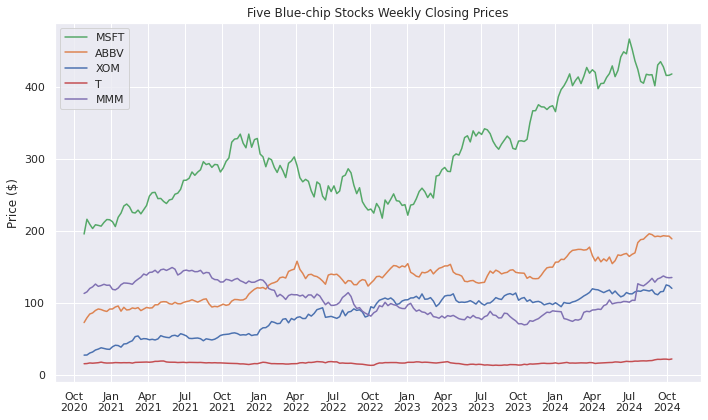

In [193]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(len(tickers)):
    date = bc5.stocks[tickers[i]].price_history.Date
    ax.plot(date, bc5.stocks[tickers[i]].price_history.Close, label=tickers[i], color=colors[i])

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Price ($)')
ax.set_title('Five Blue-chip Stocks Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [182]:
bc5_weights = pd.DataFrame(bc5.weights, index=[0])

In [183]:
bc5_weights.loc[0] =  round(bc5_weights.loc[0] * 100, 2)

In [184]:
bc5_weights

,MSFT,ABBV,XOM,T,MMM
0,73.9,7.93,12.68,3.73,1.77


In [190]:
bc5_weights.to_csv('mcap_weights.txt', sep=' ', index=False)

Text(0, 0.5, 'Market Cap %')

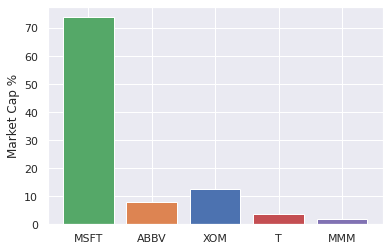

In [189]:
plt.bar(x=range(bc5_weights.shape[1]), height=bc5_weights.loc[0], color=colors, tick_label=bc5_weights.columns)
plt.ylabel('Market Cap %')

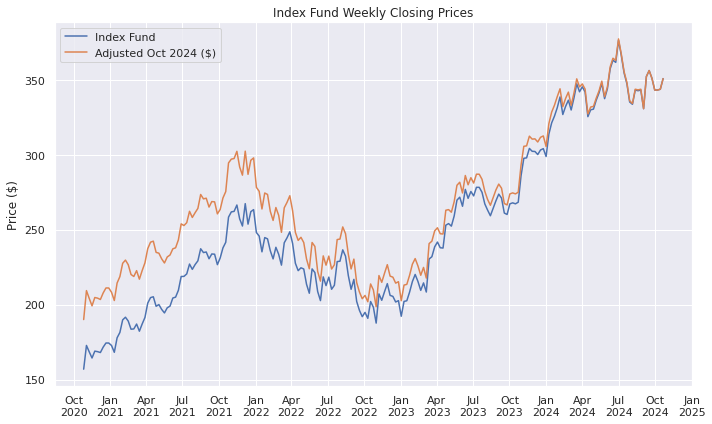

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(sc.index.Date, sc.index.Index, label='Index Fund', color='C0')
ax.plot(sc.index.Date, sc.index.Index_Adj, label='Adjusted Oct 2024 ($)', color='C1')

# Formatting the x-axis to show quarter ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))  # Quarterly ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))  # Show month and year

# Add labels and title
ax.set_xlabel('')
ax.set_ylabel('Price ($)')
ax.set_title('Index Fund Weekly Closing Prices')

# Add grid and legend
ax.grid(True)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [13]:
sc.index.head()

,Date,Index,Index_Adj
0,2020-10-26,156.954871,190.054948
1,2020-11-02,172.794552,209.362888
2,2020-11-09,168.483417,204.139392
3,2020-11-16,164.415647,199.210764
4,2020-11-23,168.994715,204.758895


In [14]:
sc.index.tail()

,Date,Index,Index_Adj
204,2024-09-23,350.951422,350.951422
205,2024-09-30,343.116777,343.116777
206,2024-10-07,343.121248,343.121248
207,2024-10-14,343.658796,343.658796
208,2024-10-21,350.735792,350.735792


In [15]:
sc.index.to_csv('bc5_index_20201026-20241021.txt', index_label='week', sep=' ')

## Distribution of weekly returns from index fund stocks

Build kernel density estimate (kde) of weekly returns

In [342]:
bc5.stocks['MSFT'].price_history.head()

,Date,Close,Volume,Dividends,Inflation_Adj
0,2020-10-26,195.590851,193393800,0.00,236.838836
1,2020-11-02,216.118896,161978000,0.00,261.855920
2,2020-11-09,209.153778,158095900,0.00,253.416781
3,2020-11-16,203.241730,125116000,0.56,246.253571
4,2020-11-23,208.461639,95188300,0.00,252.578165


In [343]:
bc5.stocks['MSFT'].price_history.shape

(208, 5)

In [344]:
bw_bounds = (-2, 1)
params = {'bandwidth': np.logspace(bw_bounds[0], bw_bounds[1], 15)}

In [345]:
grid = GridSearchCV(
                KernelDensity(kernel='gaussian'),
                params,
                cv=ShuffleSplit(n_splits=5, test_size=0.20),
                n_jobs=-1
                )

In [346]:
tickers

['MSFT', 'ABBV', 'XOM', 'T', 'MMM']

In [347]:
X_msft = bc5.stocks['MSFT'].price_history.Inflation_Adj.loc[:106]
X_abbv = bc5.stocks['ABBV'].price_history.Inflation_Adj.loc[:106]
X_xom = bc5.stocks['XOM'].price_history.Inflation_Adj.loc[:106]
X_t = bc5.stocks['T'].price_history.Inflation_Adj.loc[:106]
X_mmm = bc5.stocks['MMM'].price_history.Inflation_Adj.loc[:106]

In [348]:
eg_pct_change = {}

In [349]:
eg_pct_change['Date'] = bc5.index.Date.loc[X_msft.index.values[-1]]

In [350]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7)}

In [351]:
X_msft = pd.DataFrame(X_msft.pct_change()*100)
X_abbv = pd.DataFrame(X_abbv.pct_change()*100)
X_xom = pd.DataFrame(X_xom.pct_change()*100)
X_t = pd.DataFrame(X_t.pct_change()*100)
X_mmm = pd.DataFrame(X_mmm.pct_change()*100)

In [352]:
X_msft.index.values[-1]

106

In [353]:
X_msft.tail()

,Inflation_Adj
102,-2.424864
103,5.932792
104,-2.581356
105,-6.138975
106,11.730351


In [354]:
X_msft.loc[X_msft.index.values[-1]]

Inflation_Adj    11.730351
Name: 106, dtype: float64

In [355]:
eg_pct_change['MSFT'] = X_msft.loc[X_msft.index.values[-1]][0]
eg_pct_change['ABBV'] = X_abbv.loc[X_abbv.index.values[-1]][0]
eg_pct_change['XOM'] = X_xom.loc[X_xom.index.values[-1]][0]
eg_pct_change['T'] = X_t.loc[X_t.index.values[-1]][0]
eg_pct_change['MMM'] = X_mmm.loc[X_mmm.index.values[-1]][0]

Save the last value and drop before training the kde

In [356]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247}

In [357]:
X_msft.drop(X_msft.tail(1).index, inplace=True)
X_abbv.drop(X_abbv.tail(1).index, inplace=True)
X_xom.drop(X_xom.tail(1).index, inplace=True)
X_t.drop(X_t.tail(1).index, inplace=True)
X_mmm.drop(X_mmm.tail(1).index, inplace=True)

In [358]:
print(X_msft.tail())
print(X_abbv.tail())

     Inflation_Adj
101       0.169013
102      -2.424864
103       5.932792
104      -2.581356
105      -6.138975
     Inflation_Adj
101       2.972483
102       3.012393
103       3.929193
104       0.374004
105      -1.578476


In [359]:
X_msft.dropna(inplace=True)
X_abbv.dropna(inplace=True)
X_xom.dropna(inplace=True)
X_t.dropna(inplace=True)
X_mmm.dropna(inplace=True)

In [360]:
X_msft.head()

,Inflation_Adj
1,10.562915
2,-3.222818
3,-2.826651
4,2.568326
5,-0.404209


In [361]:
eg_pct_change['msft_5ile'] = np.percentile(X_msft, 5)
eg_pct_change['abbv_5ile'] = np.percentile(X_abbv, 5)
eg_pct_change['xom_5ile'] = np.percentile(X_xom, 5)
eg_pct_change['t_5ile'] = np.percentile(X_t, 5)
eg_pct_change['mmm_5ile'] = np.percentile(X_mmm, 5)

In [362]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247,
 'msft_5ile': -5.711491982497396,
 'abbv_5ile': -4.6347744216418585,
 'xom_5ile': -6.247127820704899,
 't_5ile': -4.458041289465437,
 'mmm_5ile': -5.530600016579948}

In [363]:
grid.fit(X_msft)
X_msft.sort_values(by='Inflation_Adj', inplace=True)
X_msft['msft_prob'] = grid.score_samples(X_msft)
X_msft['msft_prob'] = X_msft['msft_prob'].apply(np.exp)
eg_pct_change['msft_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['msft_5ile']])))
X_msft.rename(columns={'Inflation_Adj':'msft_wkly_rtrn'}, inplace=True)
X_msft.head()

,msft_wkly_rtrn,msft_prob
84,-7.576489,0.015489
98,-7.456671,0.016488
62,-7.403813,0.016935
105,-6.138975,0.029562
95,-6.112513,0.029882


In [364]:
grid.fit(X_abbv)
X_abbv.sort_values(by='Inflation_Adj', inplace=True)
X_abbv['abbv_prob'] = grid.score_samples(X_abbv)
X_abbv['abbv_prob'] = X_abbv['abbv_prob'].apply(np.exp)
eg_pct_change['abbv_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['abbv_5ile']])))
X_abbv.rename(columns={'Inflation_Adj':'abbv_wkly_rtrn'}, inplace=True)
X_abbv.head()

,abbv_wkly_rtrn,abbv_prob
13,-7.559084,0.010980
76,-7.230216,0.012704
44,-6.656621,0.015740
100,-6.186197,0.018517
78,-5.232588,0.026272


In [365]:
grid.fit(X_xom)
X_xom.sort_values(by='Inflation_Adj', inplace=True)
X_xom['xom_prob'] = grid.score_samples(X_xom)
X_xom['xom_prob'] = X_xom['xom_prob'].apply(np.exp)
eg_pct_change['xom_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['xom_5ile']])))
X_xom.rename(columns={'Inflation_Adj':'xom_wkly_rtrn'}, inplace=True)
X_xom.head()

,xom_wkly_rtrn,xom_prob
85,-14.274344,0.001912
20,-8.842982,0.009828
92,-8.716234,0.010241
99,-8.003444,0.012799
72,-7.359879,0.015597


In [366]:
grid.fit(X_t)
X_t.sort_values(by='Inflation_Adj', inplace=True)
X_t['t_prob'] = grid.score_samples(X_t)
X_t['t_prob'] = X_t['t_prob'].apply(np.exp)
eg_pct_change['t_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['t_5ile']])))
X_t.rename(columns={'Inflation_Adj':'t_wkly_rtrn'}, inplace=True)
X_t.head()

,t_wkly_rtrn,t_prob
90,-10.549323,0.002941
29,-6.916872,0.017956
85,-6.331567,0.024162
65,-5.261156,0.039429
7,-5.191858,0.040588


In [367]:
grid.fit(X_mmm)
X_mmm.sort_values(by='Inflation_Adj', inplace=True)
X_mmm['mmm_prob'] = grid.score_samples(X_mmm)
X_mmm['mmm_prob'] = X_mmm['mmm_prob'].apply(np.exp)
eg_pct_change['mmm_5ile_p']= np.exp(grid.score(pd.DataFrame([eg_pct_change['mmm_5ile']])))
X_mmm.rename(columns={'Inflation_Adj':'mmm_wkly_rtrn'}, inplace=True)
X_mmm.head()

,mmm_wkly_rtrn,mmm_prob
95,-10.147853,0.003445
68,-7.471488,0.014024
84,-6.977561,0.019007
96,-5.799927,0.032322
85,-5.673813,0.033668


In [370]:
eg_pct_change

{'Date': datetime.date(2022, 11, 7),
 'MSFT': 11.730351342576938,
 'ABBV': 3.4635229676940105,
 'XOM': 1.5628471819032264,
 'T': 4.089853229249907,
 'MMM': 6.628046012690247,
 'msft_5ile': -5.711491982497396,
 'abbv_5ile': -4.6347744216418585,
 'xom_5ile': -6.247127820704899,
 't_5ile': -4.458041289465437,
 'mmm_5ile': -5.530600016579948,
 'abbv_5ile_p': 0.03304734947950935,
 'xom_5ile_p': 0.022338072661721584,
 't_5ile_p': 0.05392974307143191,
 'mmm_5ile_p': 0.03515921779006332,
 'msft_5ile_p': 0.03510917938037208}

In [396]:
X = pd.concat([X_msft.reset_index(drop=True), X_abbv.reset_index(drop=True), X_xom.reset_index(drop=True),
              X_t.reset_index(drop=True), X_mmm.reset_index(drop=True)], axis=1)

In [379]:
X_msft.head()

,msft_wkly_rtrn,msft_prob
84,-7.576489,0.015489
98,-7.456671,0.016488
62,-7.403813,0.016935
105,-6.138975,0.029562
95,-6.112513,0.029882


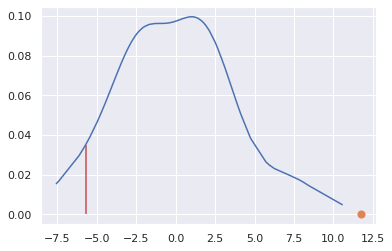

In [395]:
plt.plot(X_msft.msft_wkly_rtrn, X_msft.msft_prob, color='C0')
plt.vlines(eg_pct_change['msft_5ile'], ymin=0, ymax=eg_pct_change['msft_5ile_p'], colors='C3')
plt.scatter(eg_pct_change['MSFT'], 0, 50, marker='o', color='C1')
plt.show()

In [397]:
X.head()

,msft_wkly_rtrn,msft_prob,abbv_wkly_rtrn,abbv_prob,xom_wkly_rtrn,xom_prob,t_wkly_rtrn,t_prob,mmm_wkly_rtrn,mmm_prob
0,-7.576489,0.015489,-7.559084,0.010980,-14.274344,0.001912,-10.549323,0.002941,-10.147853,0.003445
1,-7.456671,0.016488,-7.230216,0.012704,-8.842982,0.009828,-6.916872,0.017956,-7.471488,0.014024
2,-7.403813,0.016935,-6.656621,0.015740,-8.716234,0.010241,-6.331567,0.024162,-6.977561,0.019007
3,-6.138975,0.029562,-6.186197,0.018517,-8.003444,0.012799,-5.261156,0.039429,-5.799927,0.032322
4,-6.112513,0.029882,-5.232588,0.026272,-7.359879,0.015597,-5.191858,0.040588,-5.673813,0.033668


In [398]:
X.tail()

,msft_wkly_rtrn,msft_prob,abbv_wkly_rtrn,abbv_prob,xom_wkly_rtrn,xom_prob,t_wkly_rtrn,t_prob,mmm_wkly_rtrn,mmm_prob
100,7.269610,0.019536,6.666681,0.018006,10.789572,0.016869,6.185252,0.025120,4.999593,0.028862
101,7.827632,0.017458,6.802641,0.016931,11.277271,0.014875,7.170505,0.018284,5.221323,0.025199
102,8.096115,0.016245,6.951517,0.015831,11.311450,0.014738,8.070189,0.013153,5.682656,0.019105
103,8.440157,0.014507,9.173590,0.006988,11.628116,0.013483,8.307536,0.011958,6.799881,0.010444
104,10.562915,0.004914,10.167764,0.005319,15.246621,0.003439,14.076042,0.001816,8.381167,0.004993


In [399]:
X.to_csv('bc5_pdistribution_20201026-20221107.txt', sep=' ', index=False)

In [401]:
eg_pct_change_df = pd.DataFrame(eg_pct_change, index=[0])

In [403]:
eg_pct_change_df.to_csv('eg_pct_change_5tile_threshold.txt', index=False, sep=' ')

## Enhancing DCA by prioritizing rare price drops

In [ ]:
bc5.index.Date.index[bc5.index.Date==eg_pct_change['Date']]

In [408]:
simulated_dates = bc5.index.Date.iloc[106:]

In [438]:
final_date = simulated_dates.iloc[-1]

In [409]:
simulated_dates.head()

106    2022-11-07
107    2022-11-14
108    2022-11-21
109    2022-11-28
110    2022-12-05
Name: Date, dtype: object

In [410]:
simulated_dates.tail()

203    2024-09-16
204    2024-09-23
205    2024-09-30
206    2024-10-07
207    2024-10-14
Name: Date, dtype: object

In [407]:
bc5.index.Date.index[bc5.index.Date==eg_pct_change['Date']]

Index([106], dtype='int64')

In [434]:
index_fund_investor = etk.Index_Fund(bc5, cash=500.0, cashflow=500.0)
index_fund_investor.set_cashflow_start(simulated_dates.iloc[0])

In [435]:
apd_investor = etk.Adaptive_Price_Drop(bc5, threshold=5.0, cash=500.0, cashflow=500.0)
apd_investor.set_cashflow_start(simulated_dates.iloc[0])
apd_investor.set_partial_shares(True)
# apd_investor.set_lag(104)  # Two years of price history

In [436]:
for d in simulated_dates:
    index_fund_investor.invest(d, partial_shares=True)
    apd_investor.apd_invest(d)

/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:347: RuntimeWarning: divide by zero encountered in scalar power
  
/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:352: RuntimeWarning: invalid value encountered in scalar divide
  if ndx < 30:
/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:347: RuntimeWarning: divide by zero encountered in scalar power
  
/home/drew/projects/portfolio_projects/stock_analytics/equities_value_simulator/equities_toolkit.py:352: RuntimeWarning: invalid value encountered in scalar divide
  if ndx < 30:


In [437]:
apd_investor.purchases

[{'Date': datetime.date(2022, 11, 7),
  'MSFT': (1.5210885048078993, 242.92),
  'ABBV': (0.2848161551967824, 139.24),
  'XOM': (0.5947727614943638, 106.57),
  'T': (1.107982124633342, 16.81),
  'MMM': (0.08764693750087112, 100.7),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2022, 11, 14), 'Action': 'Price Out'},
 {'Date': datetime.date(2022, 11, 21),
  'MSFT': (1.514484765317378, 243.98),
  'ABBV': (0.2679362703211667, 148.01),
  'XOM': (0.593879718173335, 106.73),
  'T': (1.1039256499534382, 16.87),
  'MMM': (0.08927770162289969, 98.86),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2022, 11, 28), 'Action': 'Price Out'},
 {'Date': datetime.date(2022, 12, 5),
  'MSFT': (1.5272588806974219, 241.94),
  'ABBV': (0.2622837511705835, 151.2),
  'XOM': (0.6493444239342293, 97.61),
  'T': (1.10566046056147, 16.85),
  'MMM': (0.09160619296028928, 96.34),
  'Action': 'Buy Index'},
 {'Date': datetime.date(2022, 12, 12), 'Action': 'Price Out'},
 {'Date': datetime.date(2022, 12, 19),
  'M

In [440]:
apd_purchases_df = pd.DataFrame(apd_investor.purchases)

In [441]:
apd_purchases_df.head()

,Date,MSFT,ABBV,XOM,T,MMM,Action
0,2022-11-07,"(1.5210885048078993, 242.92)","(0.2848161551967824, 139.24)","(0.5947727614943638, 106.57)","(1.107982124633342, 16.81)","(0.08764693750087112, 100.7)",Buy Index
1,2022-11-14,NaN,NaN,NaN,NaN,NaN,Price Out
2,2022-11-21,"(1.514484765317378, 243.98)","(0.2679362703211667, 148.01)","(0.593879718173335, 106.73)","(1.1039256499534382, 16.87)","(0.08927770162289969, 98.86)",Buy Index
3,2022-11-28,NaN,NaN,NaN,NaN,NaN,Price Out
4,2022-12-05,"(1.5272588806974219, 241.94)","(0.2622837511705835, 151.2)","(0.6493444239342293, 97.61)","(1.10566046056147, 16.85)","(0.09160619296028928, 96.34)",Buy Index


In [442]:
apd_purchases_df_clean = apd_purchases_df.dropna()

In [443]:
apd_purchases_df_clean.head()

,Date,MSFT,ABBV,XOM,T,MMM,Action
0,2022-11-07,"(1.5210885048078993, 242.92)","(0.2848161551967824, 139.24)","(0.5947727614943638, 106.57)","(1.107982124633342, 16.81)","(0.08764693750087112, 100.7)",Buy Index
2,2022-11-21,"(1.514484765317378, 243.98)","(0.2679362703211667, 148.01)","(0.593879718173335, 106.73)","(1.1039256499534382, 16.87)","(0.08927770162289969, 98.86)",Buy Index
4,2022-12-05,"(1.5272588806974219, 241.94)","(0.2622837511705835, 151.2)","(0.6493444239342293, 97.61)","(1.10566046056147, 16.85)","(0.09160619296028928, 96.34)",Buy Index
6,2022-12-19,"(1.5700575764472204, 235.35)","(0.2622194475110538, 151.24)","(0.6186338381486788, 102.46)","(1.1527615658473889, 16.16)","(0.0958914170063212, 92.04)",Buy Index
8,2023-01-02,"(1.9302277371672527, 221.74)","(0.10139339138607746, 154.44)","(0.3080559070035233, 104.2)","(0.7096017007543208, 17.23)","(0.12361346323676942, 97.08)",Buy APD


In [458]:
def split_shares_prices(df, columns):
    df = df.copy()
    for col in columns:
        col_name = col+'_shares'
        df[col_name] = df[col].apply(lambda x: x[0])
        col_name = col+'_price'
        df[col_name] = df[col].apply(lambda x: x[1])
        df = df.drop(columns=col)
    return(df)

In [504]:
def calc_cost_gains(df, columns, prices):
    cost_df = pd.DataFrame()
    for col in columns:
        col_name = col+'_cost'
        cost_df[col_name] = df[col].apply(lambda x: x[0]*x[1])
        col_name = col+'_gl'
        cost_df[col_name] = df[col].apply(lambda x: x[0]*prices[col] - x[0]*x[1])
    return(cost_df)

In [465]:
apd_purchases_df_clean = split_shares_prices(apd_purchases_df_clean, tickers)

In [470]:
if_purchases_df = pd.DataFrame(index_fund_investor.purchases)

In [471]:
if_purchases_df_clean = if_purchases_df.dropna()

In [472]:
if_purchases_df_clean = split_shares_prices(if_purchases_df_clean, tickers)

In [518]:
if_purchases_df_clean.head()

,Date,Action,MSFT_shares,MSFT_price,ABBV_shares,ABBV_price,XOM_shares,XOM_price,T_shares,T_price,MMM_shares,MMM_price
0,2022-11-07,Buy Index,1.521089,242.92,0.284816,139.24,0.594773,106.57,1.107982,16.81,0.087647,100.70
2,2022-11-21,Buy Index,1.514485,243.98,0.267936,148.01,0.593880,106.73,1.103926,16.87,0.089278,98.86
4,2022-12-05,Buy Index,1.527259,241.94,0.262284,151.20,0.649344,97.61,1.105660,16.85,0.091606,96.34
6,2022-12-19,Buy Index,1.570058,235.35,0.262219,151.24,0.618634,102.46,1.152762,16.16,0.095891,92.04
8,2023-01-02,Buy Index,1.666384,221.74,0.256788,154.44,0.608279,104.20,1.080751,17.23,0.090912,97.08


In [519]:
if_purchases_df_clean.to_csv('if_purchases_cleaned.txt', index_label='week', sep=' ')

In [520]:
apd_purchases_df_clean.head()

,Date,Action,MSFT_shares,MSFT_price,ABBV_shares,ABBV_price,XOM_shares,XOM_price,T_shares,T_price,MMM_shares,MMM_price
0,2022-11-07,Buy Index,1.521089,242.92,0.284816,139.24,0.594773,106.57,1.107982,16.81,0.087647,100.70
2,2022-11-21,Buy Index,1.514485,243.98,0.267936,148.01,0.593880,106.73,1.103926,16.87,0.089278,98.86
4,2022-12-05,Buy Index,1.527259,241.94,0.262284,151.20,0.649344,97.61,1.105660,16.85,0.091606,96.34
6,2022-12-19,Buy Index,1.570058,235.35,0.262219,151.24,0.618634,102.46,1.152762,16.16,0.095891,92.04
8,2023-01-02,Buy APD,1.930228,221.74,0.101393,154.44,0.308056,104.20,0.709602,17.23,0.123613,97.08


In [521]:
apd_purchases_df_clean.to_csv('apd_purchases_cleaned.txt', index_label='week', sep=' ')

In [464]:
apd_purchases_df_clean.Action.value_counts()

Action
Buy Index    42
Buy APD       9
Name: count, dtype: int64

In [483]:
if_avg_std = {}
apd_avg_std = {}

In [485]:
if_avg_std['msft_avg'], if_avg_std['msft_std'] = weighted_avg_and_std(if_purchases_df_clean.MSFT_price, if_purchases_df_clean.MSFT_shares)
if_avg_std['abbv_avg'], if_avg_std['abbv_std'] = weighted_avg_and_std(if_purchases_df_clean.ABBV_price, if_purchases_df_clean.ABBV_shares)
if_avg_std['xom_avg'], if_avg_std['xom_std'] = weighted_avg_and_std(if_purchases_df_clean.XOM_price, if_purchases_df_clean.XOM_shares)
if_avg_std['t_avg'], if_avg_std['t_std'] = weighted_avg_and_std(if_purchases_df_clean.T_price, if_purchases_df_clean.T_shares)
if_avg_std['mmm_avg'], if_avg_std['mmm_std'] = weighted_avg_and_std(if_purchases_df_clean.MMM_price, if_purchases_df_clean.MMM_shares)


In [486]:
apd_avg_std['msft_avg'], apd_avg_std['msft_std'] = weighted_avg_and_std(apd_purchases_df_clean.MSFT_price, apd_purchases_df_clean.MSFT_shares)
apd_avg_std['abbv_avg'], apd_avg_std['abbv_std'] = weighted_avg_and_std(apd_purchases_df_clean.ABBV_price, apd_purchases_df_clean.ABBV_shares)
apd_avg_std['xom_avg'], apd_avg_std['xom_std'] = weighted_avg_and_std(apd_purchases_df_clean.XOM_price, apd_purchases_df_clean.XOM_shares)
apd_avg_std['t_avg'], apd_avg_std['t_std'] = weighted_avg_and_std(apd_purchases_df_clean.T_price, apd_purchases_df_clean.T_shares)
apd_avg_std['mmm_avg'], apd_avg_std['mmm_std'] = weighted_avg_and_std(apd_purchases_df_clean.MMM_price, apd_purchases_df_clean.MMM_shares)


In [487]:
avg_std = pd.DataFrame([if_avg_std, apd_avg_std], index=['if', 'apd'])

In [488]:
avg_std

,msft_avg,msft_std,abbv_avg,abbv_std,xom_avg,xom_std,t_avg,t_std,mmm_avg,mmm_std
if,334.979454,69.701788,152.147751,17.846774,106.467824,6.907012,16.189348,2.001696,88.645479,15.268496
apd,339.097114,70.117378,149.551351,16.344348,105.148647,7.177537,15.618926,1.755587,88.965960,10.213364


In [489]:
avg_std.to_csv('dca_strategy_avg_std.txt', index_label='strategy', sep=' ')

In [498]:
X_if = if_purchases_df.dropna().drop(columns=['Action'])

In [499]:
X_apd = apd_purchases_df.dropna().drop(columns=['Action'])

In [496]:
X_if.head()

,MSFT,ABBV,XOM,T,MMM
0,"(1.5210885048078993, 242.92)","(0.2848161551967824, 139.24)","(0.5947727614943638, 106.57)","(1.107982124633342, 16.81)","(0.08764693750087112, 100.7)"
2,"(1.514484765317378, 243.98)","(0.2679362703211667, 148.01)","(0.593879718173335, 106.73)","(1.1039256499534382, 16.87)","(0.08927770162289969, 98.86)"
4,"(1.5272588806974219, 241.94)","(0.2622837511705835, 151.2)","(0.6493444239342293, 97.61)","(1.10566046056147, 16.85)","(0.09160619296028928, 96.34)"
6,"(1.5700575764472204, 235.35)","(0.2622194475110538, 151.24)","(0.6186338381486788, 102.46)","(1.1527615658473889, 16.16)","(0.0958914170063212, 92.04)"
8,"(1.666384480611656, 221.74)","(0.2567877003851033, 154.44)","(0.6082793990023653, 104.2)","(1.080750680369371, 17.23)","(0.09091220528648665, 97.08)"


In [491]:
final_date

datetime.date(2024, 10, 14)

In [493]:
final_prices = bc5.get_prices(final_date)
final_prices

{'MSFT': 418.1600036621094,
 'ABBV': 188.86000061035156,
 'XOM': 120.01000213623047,
 'T': 21.850000381469727,
 'MMM': 135.13999938964844}

In [505]:
if_cost_gain = calc_cost_gains(X_if, tickers, final_prices)

In [506]:
if_cost_gain.head()

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
0,369.502820,266.555555,39.657801,14.132578,63.384933,7.993747,18.625180,5.584230,8.826047,3.018560
2,369.503993,263.792962,39.657247,10.945197,63.384782,7.886724,18.623226,5.497550,8.825994,3.238995
4,369.505014,269.133566,39.657303,9.877606,63.382509,14.545316,18.630379,5.528303,8.825341,3.554320
6,369.513051,287.022231,39.658069,9.864696,63.385223,10.857025,18.628627,6.559214,8.825846,4.132920
8,369.504095,327.311246,39.658292,8.838633,63.382713,9.616899,18.621334,4.993069,8.825757,3.460118


In [507]:
apd_cost_gain = calc_cost_gains(X_apd, tickers, final_prices)

In [509]:
apd_cost_gain.head()

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
0,369.502820,266.555555,39.657801,14.132578,63.384933,7.993747,18.625180,5.584230,8.826047,3.018560
2,369.503993,263.792962,39.657247,10.945197,63.384782,7.886724,18.623226,5.497550,8.825994,3.238995
4,369.505014,269.133566,39.657303,9.877606,63.382509,14.545316,18.630379,5.528303,8.825341,3.554320
6,369.513051,287.022231,39.658069,9.864696,63.385223,10.857025,18.628627,6.559214,8.825846,4.132920
8,428.008698,379.135339,15.659195,3.489961,32.099426,4.870365,12.226437,3.278360,12.000395,4.704728


In [513]:
gl = [if_cost_gain.apply(np.sum, axis=0).to_dict(), apd_cost_gain.apply(np.sum, axis=0).to_dict()]

In [515]:
gl = pd.DataFrame(gl, index=['if', 'apd'])

In [516]:
gl

,MSFT_cost,MSFT_gl,ABBV_cost,ABBV_gl,XOM_cost,XOM_gl,T_cost,T_gl,MMM_cost,MMM_gl
if,18844.800229,4679.453683,2022.540375,488.025658,3232.664737,411.178887,949.848498,332.117241,450.109893,236.082466
apd,16141.831781,3763.582214,2793.202523,734.176042,3655.230904,516.618024,1623.667345,647.752038,1286.038456,667.464172


In [517]:
gl.to_csv('dca_strategy_gains.txt', index_label='strategy', sep=' ')